In [ ]:
import os
import re
import pandas as pd
from pathlib import Path
from typing import List, Dict
from PyPDF2 import PdfReader
import spacy

# Setup
DATA_DIR_TERMINATED = "./Data/terminated_trials"
DATA_DIR_COMPLETED = "./Data/completed_trials"
OUTPUT_DIR = "./Data/reprocessing"
OUTPUT_FILE = "combined_icfs.csv"

# Load SpaCy language model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

def extract_text_from_pdf(pdf_path: str) -> str:
    """
    Extracts and concatenates text from a PDF file.
    """
    reader = PdfReader(pdf_path)
    text = " ".join([page.extract_text() or "" for page in reader.pages])
    return text

def clean_and_normalize_text(text: str) -> str:
    """
    Cleans and normalizes raw text using basic NLP steps.
    """
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    doc = nlp(text)
    lemmatized = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return lemmatized

def process_icfs(directory: str, trial_status: str) -> pd.DataFrame:
    """
    Processes all ICF PDFs in a directory and labels them by trial status.
    """
    records: List[Dict] = []

    for file in Path(directory).rglob("*.pdf"):
        try:
            raw_text = extract_text_from_pdf(str(file))
            clean_text = clean_and_normalize_text(raw_text)
            records.append({
                "file_name": file.name,
                "file_path": str(file),
                "raw_text": raw_text,
                "clean_text": clean_text,
                "word_count": len(clean_text.split()),
                "trial_status": trial_status  # Label as 'terminated' or 'completed'
            })
        except Exception as e:
            print(f"[ERROR] Failed to process {file}: {e}")

    return pd.DataFrame(records)

def main():
    """
    Main function to process all trials and save combined data.
    """
    # Process terminated and completed trials separately
    df_terminated = process_icfs(DATA_DIR_TERMINATED, trial_status="terminated")
    df_completed = process_icfs(DATA_DIR_COMPLETED, trial_status="completed")

    # Combine datasets
    combined_df = pd.concat([df_terminated, df_completed], ignore_index=True)

    # Ensure output directory exists
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILE)
    combined_df.to_csv(output_path, index=False)

    print(f"[INFO] Combined dataset saved successfully at {output_path}")

if __name__ == "__main__":
    main()


c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\PyPDF2\_cmap.py:142: PdfReadWarning: Advanced encoding /SymbolSetEncoding not implemented yet
  warnings.warn(


[INFO] Combined dataset saved successfully at ./Data/reprocessing\combined_icfs.csv


In [ ]:
import pandas as pd
CSV_PATH = "./Data/reprocessing/combined_icfs.csv"

def summarize_trial_status(csv_path: str):
    """
    Reads the combined ICF dataset and prints the count of each trial status.
    """
    try:
        df = pd.read_csv(csv_path)

        # Count occurrences of each status
        status_counts = df['trial_status'].value_counts()

        print("rial Status Summary:")
        for status, count in status_counts.items():
            print(f"  → {status.capitalize()}: {count} trials")

    except FileNotFoundError:
        print(f"[ERROR] File not found: {csv_path}")
    except Exception as e:
        print(f"[ERROR] An error occurred: {e}")

if __name__ == "__main__":
    summarize_trial_status(CSV_PATH)



rial Status Summary:
  → Completed: 53 trials
  → Terminated: 35 trials


In [ ]:
import pandas as pd

CSV_PATH = "./Data/reprocessing/combined_icfs.csv"

def check_empty_clean_text_by_status(csv_path: str):
    """
    Checks for empty or whitespace-only clean_text entries, grouped by trial_status.
    """
    try:
        df = pd.read_csv(csv_path)

        # Strip whitespace and check for emptiness
        df['clean_text'] = df['clean_text'].astype(str).str.strip()
        empty_df = df[df['clean_text'] == ""]

        # Group by trial_status and count
        grouped_counts = empty_df.groupby('trial_status').size()

        print("🔍 Empty `clean_text` Check by Trial Status:")
        if grouped_counts.empty:
            print("No empty clean_text entries found for any trial status.")
        else:
            for status, count in grouped_counts.items():
                print(f"{count} empty clean_text row(s) in '{status}' trials")

            # Optionally: show filenames for inspection
            print("\nDetails of affected rows:")
            print(empty_df[['file_name', 'trial_status']])

    except FileNotFoundError:
        print(f"[ERROR] File not found: {csv_path}")
    except Exception as e:
        print(f"[ ERROR] An error occurred: {e}")

if __name__ == "__main__":
    check_empty_clean_text_by_status(CSV_PATH)


🔍 Empty `clean_text` Check by Trial Status:
3 empty clean_text row(s) in 'completed' trials
1 empty clean_text row(s) in 'terminated' trials

Details of affected rows:
                                            file_name trial_status
5   Boston Scientific Corporation (need processing...   terminated
44                       Cardinal Health 414, LLC.pdf    completed
60                   Midland Research Group, Inc..pdf    completed
78                 Santalis Pharmaceuticals, Inc..pdf    completed


In [2]:
import pandas as pd
import numpy as np
import difflib
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Paths
CSV_PATH = "./Data/reprocessing/combined_icfs.csv"

# Initialize Sentence-BERT model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def load_and_prepare_data(csv_path: str) -> pd.DataFrame:
    """
    Load combined ICF data, clean empty rows.
    """
    df = pd.read_csv(csv_path)
    df['clean_text'] = df['clean_text'].astype(str).str.strip()
    df = df[df['clean_text'] != ""].reset_index(drop=True)
    print(f"[INFO] Loaded {len(df)} documents after removing empty clean_text.")
    return df

def compute_sentence_embeddings(texts: list) -> np.ndarray:
    """
    Computes embeddings for a list of texts.
    """
    embeddings = embedding_model.encode(texts, batch_size=32, show_progress_bar=True)
    return embeddings

def compute_cosine_similarity_matrix(embeddings: np.ndarray) -> np.ndarray:
    """
    Computes pairwise cosine similarity matrix.
    """
    similarity_matrix = cosine_similarity(embeddings)
    return similarity_matrix

def compute_edit_distance_matrix(texts: list) -> np.ndarray:
    """
    Computes normalized edit distance (1 - similarity) using difflib.
    """
    n = len(texts)
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            seq = difflib.SequenceMatcher(None, texts[i], texts[j])
            similarity = seq.ratio()  # 1.0 = identical, 0.0 = totally different
            distance = 1 - similarity
            matrix[i, j] = distance
            matrix[j, i] = distance  # symmetric matrix

    return matrix

def main():
    # Step 1: Load and prepare
    df = load_and_prepare_data(CSV_PATH)

    # Step 2: Compute sentence embeddings
    embeddings = compute_sentence_embeddings(df['clean_text'].tolist())

    # Step 3: Compute cosine similarity
    cosine_sim_matrix = compute_cosine_similarity_matrix(embeddings)
    print(f"[INFO] Cosine similarity matrix shape: {cosine_sim_matrix.shape}")

    # Step 4: Compute edit distances (now with difflib)
    edit_distance_matrix = compute_edit_distance_matrix(df['clean_text'].tolist())
    print(f"[INFO] Edit distance matrix shape: {edit_distance_matrix.shape}")

    # Step 5: Save matrices
    np.save("./Data/reprocessing/cosine_similarity.npy", cosine_sim_matrix)
    np.save("./Data/reprocessing/edit_distance.npy", edit_distance_matrix)
    print("[INFO] Similarity matrices saved successfully.")

if __name__ == "__main__":
    main()


c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\franc\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

[INFO] Loaded 84 documents after removing empty clean_text.


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Cosine similarity matrix shape: (84, 84)
[INFO] Edit distance matrix shape: (84, 84)
[INFO] Similarity matrices saved successfully.


## implementation phase for Cosine Similarity.

In [11]:
import pandas as pd

CSV_PATH = "./Data/reprocessing/combined_icfs.csv"

def confirm_trial_grouping():
    """
    Confirms that rows 0–33 are 'terminated' and rows 34–83 are 'completed'.
    """
    df = pd.read_csv(CSV_PATH)
    df['clean_text'] = df['clean_text'].astype(str).str.strip()
    df = df[df['clean_text'] != ""].reset_index(drop=True)

    # Check status distribution in each segment
    first_group = df.iloc[:34]['trial_status'].unique()
    second_group = df.iloc[34:]['trial_status'].unique()

    print("Trial Group Status Confirmation")
    print(f"Trials 1–34 status: {first_group}")
    print(f"Trials 35–84 status: {second_group}")

    if len(first_group) == 1 and first_group[0] == "terminated" and \
       len(second_group) == 1 and second_group[0] == "completed":
        print("Trial grouping is correct.")
    else:
        print("Mismatch detected. Please review group indexing or data order.")

if __name__ == "__main__":
    confirm_trial_grouping()


Trial Group Status Confirmation
Trials 1–34 status: ['terminated']
Trials 35–84 status: ['completed']
Trial grouping is correct.


[INFO] Saved ordered heatmap to: ./Data/reprocessing/ordered_cosine_similarity_heatmap.png


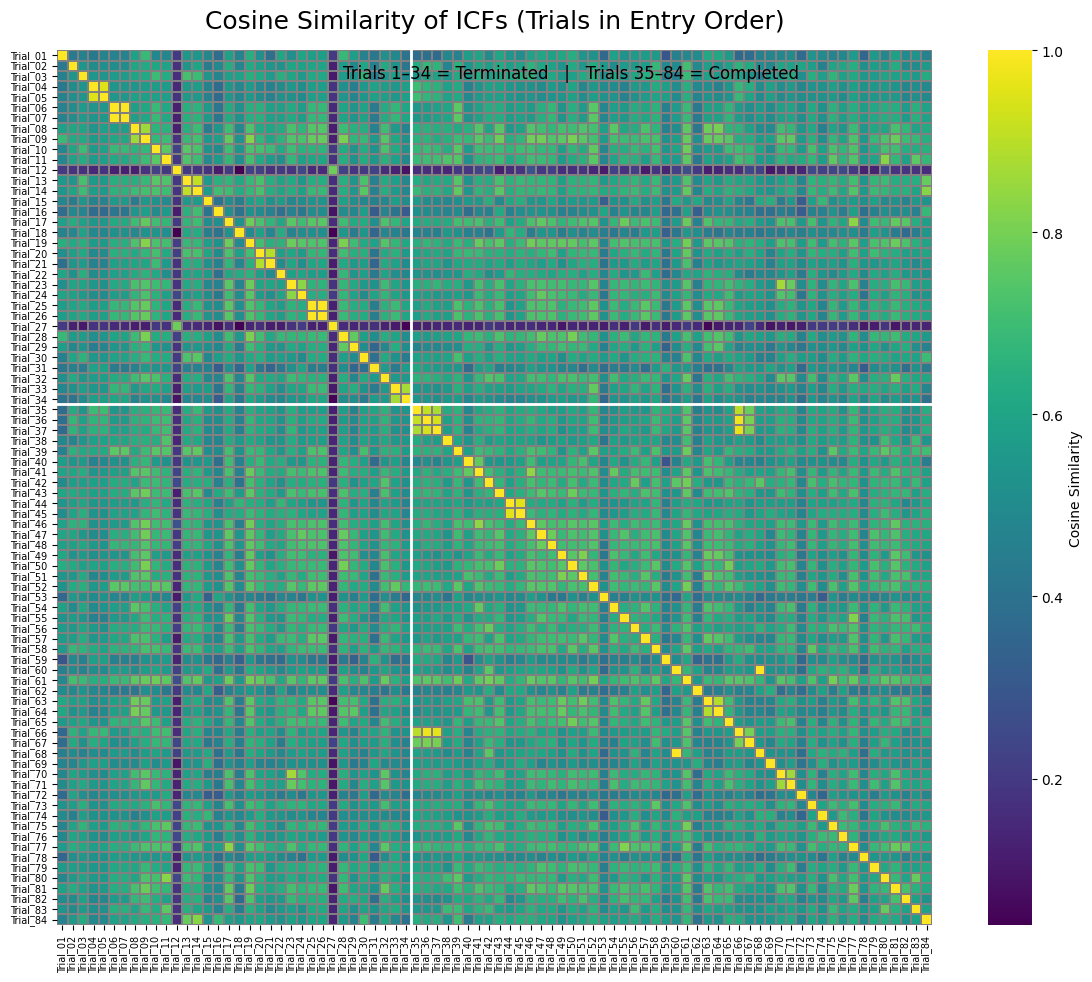

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

CSV_PATH = "./Data/reprocessing/combined_icfs.csv"
COSINE_PATH = "./Data/reprocessing/cosine_similarity.npy"

def plot_ordered_cosine_heatmap(matrix, labels, split_index=34, save_path=None):
    """
    Plots cosine similarity heatmap in original trial order with group annotation.
    """
    # Create generic trial labels
    trial_ids = [f"Trial_{i+1:02}" for i in range(len(labels))]

    # Plot
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(matrix, xticklabels=trial_ids, yticklabels=trial_ids,
                     cmap="viridis", square=True, cbar_kws={"label": "Cosine Similarity"},
                     linewidths=0.2, linecolor='grey')

    # Add horizontal/vertical split line after Trial_34
    ax.axhline(split_index, color="white", lw=2)
    ax.axvline(split_index, color="white", lw=2)

    # Titles
    plt.title("Cosine Similarity of ICFs (Trials in Entry Order)", fontsize=18, pad=16)
    plt.suptitle("Trials 1–34 = Terminated   |   Trials 35–84 = Completed", fontsize=12, y=0.91)

    # Axis formatting
    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(rotation=0, fontsize=7)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[INFO] Saved ordered heatmap to: {save_path}")

    plt.tight_layout()
    plt.show()

def main():
    df = pd.read_csv(CSV_PATH)
    df['clean_text'] = df['clean_text'].astype(str).str.strip()
    df = df[df['clean_text'] != ""].reset_index(drop=True)

    cosine_matrix = np.load(COSINE_PATH)
    labels = df['file_name'].tolist()

    plot_ordered_cosine_heatmap(
        matrix=cosine_matrix,
        labels=labels,
        split_index=34,
        save_path="./Data/reprocessing/ordered_cosine_similarity_heatmap.png"
    )

if __name__ == "__main__":
    main()


Figure 1 illustrates the pairwise cosine similarity between informed consent forms (ICFs), arranged in entry order from Trial 1 to Trial 84. Trials 1–34 represent those that were terminated, while Trials 35–84 were successfully completed. Cosine similarity values, derived from Sentence-BERT embeddings, quantify semantic closeness between documents on a scale from 0 to 1, where 1 denotes identical content and 0 indicates no measurable similarity.

The heatmap reveals substantial variability in similarity scores across trials, with generally brighter diagonals (i.e., higher similarity) within both groups. However, no clear block of homogeneity appears to dominate the terminated group, contrary to the hypothesis that such trials might rely on more standardised or templated language. Instead, both groups exhibit a spectrum of similarity, suggesting linguistic heterogeneity in ICF design regardless of trial outcome.


article caption: Cosine similarity heatmap of informed consent forms (ICFs), computed using Sentence-BERT embeddings. Trials 1–34 are terminated; Trials 35–84 are completed. Brighter cells indicate stronger semantic similarity.

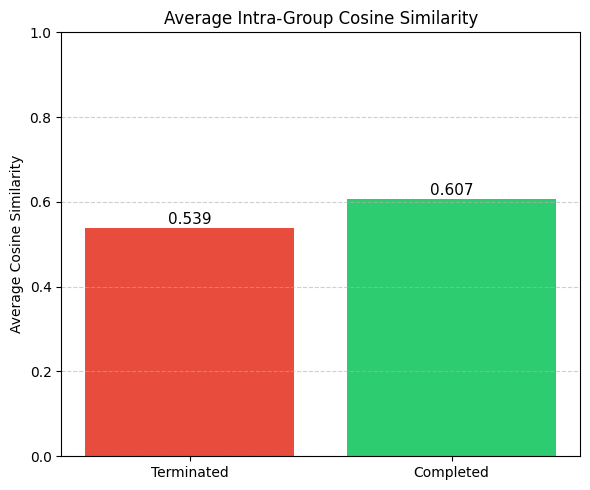

Terminated trials average similarity: 0.539
Completed trials average similarity: 0.607


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

CSV_PATH = "./Data/reprocessing/combined_icfs.csv"
COSINE_PATH = "./Data/reprocessing/cosine_similarity.npy"

def compute_avg_cosine_by_group():
    """
    Computes and plots average cosine similarity for terminated and completed groups.
    """
    # Load data
    df = pd.read_csv(CSV_PATH)
    df['clean_text'] = df['clean_text'].astype(str).str.strip()
    df = df[df['clean_text'] != ""].reset_index(drop=True)

    cosine_matrix = np.load(COSINE_PATH)
    statuses = df['trial_status'].tolist()

    # Index groups
    idx_terminated = [i for i, s in enumerate(statuses) if s == "terminated"]
    idx_completed = [i for i, s in enumerate(statuses) if s == "completed"]

    def group_pairwise_similarity(indices):
        pairs = list(combinations(indices, 2))
        values = [cosine_matrix[i, j] for i, j in pairs]
        return values

    # Get pairwise similarity scores
    terminated_scores = group_pairwise_similarity(idx_terminated)
    completed_scores = group_pairwise_similarity(idx_completed)

    # Calculate means
    mean_terminated = np.mean(terminated_scores)
    mean_completed = np.mean(completed_scores)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.bar(["Terminated", "Completed"], [mean_terminated, mean_completed],
            color=["#e74c3c", "#2ecc71"])
    plt.ylabel("Average Cosine Similarity")
    plt.title("Average Intra-Group Cosine Similarity")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for i, val in enumerate([mean_terminated, mean_completed]):
        plt.text(i, val + 0.01, f"{val:.3f}", ha='center', fontsize=11)

    plt.tight_layout()
    plt.savefig("./Data/reprocessing/avg_cosine_similarity_by_group.png", dpi=300)
    plt.show()

    print(f"Terminated trials average similarity: {mean_terminated:.3f}")
    print(f"Completed trials average similarity: {mean_completed:.3f}")

if __name__ == "__main__":
    compute_avg_cosine_by_group()


Figure 2 presents the average intra-group cosine similarity among terminated and completed trials, respectively. Contrary to expectations, completed trials exhibit a higher mean similarity (0.607) than terminated trials (0.539). This suggests that ICFs from completed trials are, on average, more semantically consistent with one another than those from trials that were terminated prematurely.

One possible interpretation is that completed trials may adhere more closely to established templates or regulatory standards for consent documentation, whereas terminated trials might vary more in structure, tone, or content due to less mature development, differing sponsor practices, or insufficient harmonisation of trial documentation processes.

article caption: Bar plot comparing average intra-group cosine similarity. Completed trials show greater internal semantic alignment than terminated trials, contrary to the initial hypothesis.

## implementation phase for Jaccard Similarity over ethical clauses.

In [13]:
import re
from typing import Dict

# Clause definitions based on international regulatory guidance
CLAUSE_PATTERNS = {
    "purpose": r"\b(purpose|objective|goal of this study)\b",
    "voluntary_participation": r"\b(voluntary|choose|no obligation|free to withdraw)\b",
    "withdrawal_rights": r"\b(withdraw|stop participation|leave the study|any time)\b",
    "study_procedures": r"\b(study procedures|what will happen|tests|visits|intervention)\b",
    "risks": r"\b(risk|side effects|discomfort|harm|complication)\b",
    "benefits": r"\b(benefit|help|positive outcome|advantage)\b",
    "alternatives": r"\b(alternative|other treatment|option)\b",
    "confidentiality": r"\b(confidential|privacy|gdpr|data protection|secure data|anonymised)\b",
    "compensation": r"\b(compensation|reimbursement|injury|medical costs)\b",
    "expenses_payments": r"\b(expense|payment|incentive|reimbursement)\b",
    "contact_info": r"\b(contact|phone|email|ask questions|study doctor)\b",
    "consent_statement": r"\b(understand|agree|sign|consent|permission)\b",
    "data_sharing": r"\b(data sharing|third party|registry|public databases)\b",
    "future_use": r"\b(store|biobank|future use|reuse|samples)\b",
    "ethics_approval": r"\b(irb|ethics committee|rec|approved)\b"
}

def extract_clause_presence(text: str) -> Dict[str, int]:
    """
    Detects presence of standard ethical clauses in cleaned ICF text.
    Returns a dictionary of binary indicators.
    """
    clauses = {}
    for clause, pattern in CLAUSE_PATTERNS.items():
        found = bool(re.search(pattern, text, flags=re.IGNORECASE))
        clauses[clause] = int(found)
    return clauses


In [14]:
import pandas as pd

CSV_PATH = "./Data/reprocessing/combined_icfs.csv"

def generate_clause_matrix():
    """
    Applies clause extraction across all clean_text documents.
    Saves a binary clause matrix for Jaccard analysis.
    """
    df = pd.read_csv(CSV_PATH)
    df['clean_text'] = df['clean_text'].astype(str).str.strip()
    df = df[df['clean_text'] != ""].reset_index(drop=True)

    clause_vectors = df['clean_text'].apply(extract_clause_presence)
    clause_df = pd.DataFrame(list(clause_vectors))
    clause_df.index = df['file_name']

    clause_df.to_csv("./Data/reprocessing/clause_matrix.csv", index=True)
    print(f"[INFO] Saved clause matrix: {clause_df.shape[0]} documents × {clause_df.shape[1]} clauses")

    return clause_df

if __name__ == "__main__":
    generate_clause_matrix()


[INFO] Saved clause matrix: 84 documents × 15 clauses


[INFO] Saved Jaccard heatmap to: ./Data/reprocessing/jaccard_similarity_heatmap.png


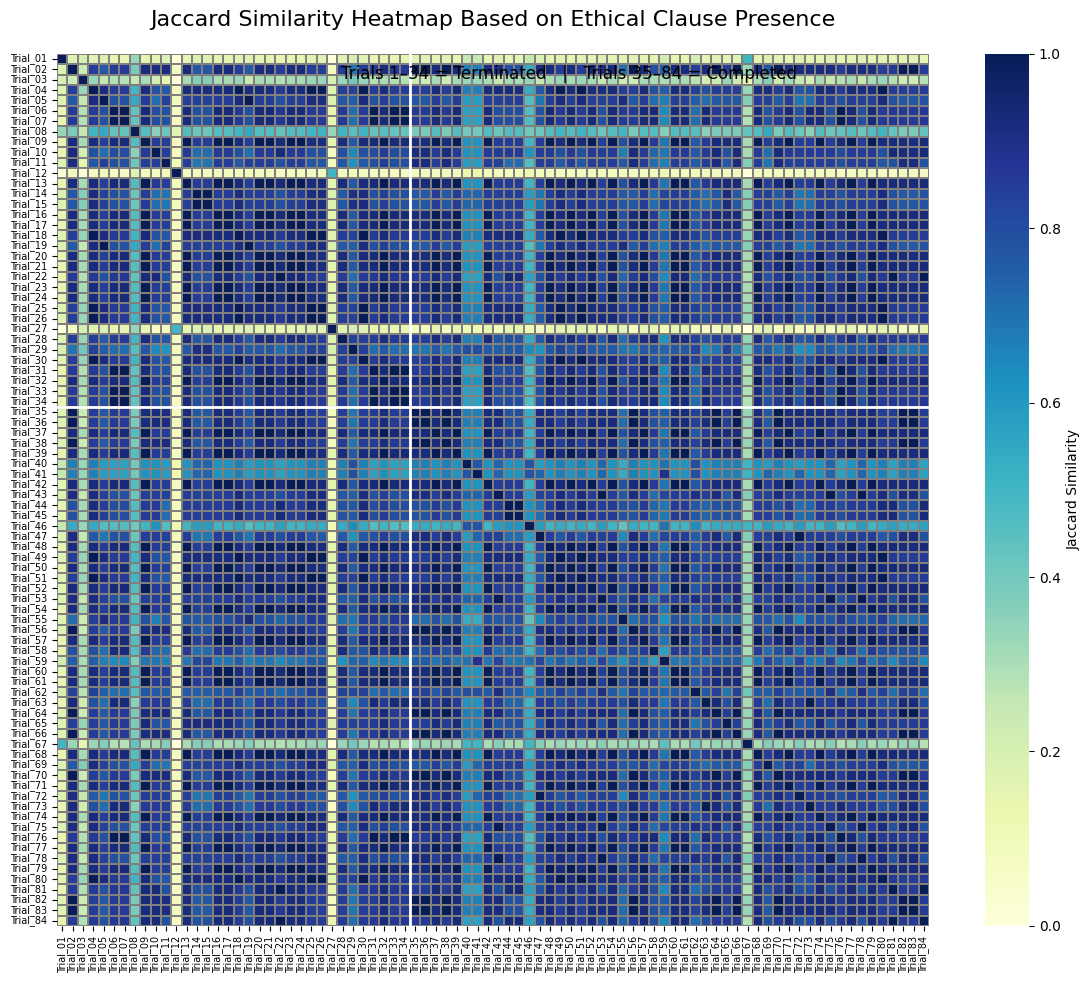

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

CSV_PATH = "./Data/reprocessing/combined_icfs.csv"
CLAUSE_MATRIX_PATH = "./Data/reprocessing/clause_matrix.csv"

def compute_jaccard_matrix(clause_df: pd.DataFrame) -> np.ndarray:
    """
    Computes pairwise Jaccard similarity between clause vectors.
    """
    n = clause_df.shape[0]
    jaccard_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            score = jaccard_score(clause_df.iloc[i], clause_df.iloc[j])
            jaccard_matrix[i, j] = score
            jaccard_matrix[j, i] = score  # Symmetry

    return jaccard_matrix

def plot_jaccard_heatmap(jaccard_matrix: np.ndarray, labels: list, statuses: list, save_path=None):
    """
    Plots a simple readable Jaccard heatmap ordered by trial entry.
    """
    trial_ids = [f"Trial_{i+1:02}" for i in range(len(labels))]

    # Sort by original trial order (Trial 01 - 84)
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(jaccard_matrix, xticklabels=trial_ids, yticklabels=trial_ids,
                     cmap="YlGnBu", square=True, cbar_kws={"label": "Jaccard Similarity"},
                     linewidths=0.2, linecolor='grey')

    # Draw division line (trial 1–34 terminated, 35–84 completed)
    ax.axhline(34, color="white", lw=2)
    ax.axvline(34, color="white", lw=2)

    # Titles
    plt.title("Jaccard Similarity Heatmap Based on Ethical Clause Presence", fontsize=16, pad=20)
    plt.suptitle("Trials 1–34 = Terminated   |   Trials 35–84 = Completed", fontsize=12, y=0.91)

    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(rotation=0, fontsize=7)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[INFO] Saved Jaccard heatmap to: {save_path}")

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    clause_df = pd.read_csv(CLAUSE_MATRIX_PATH, index_col=0)
    metadata = pd.read_csv(CSV_PATH)
    metadata = metadata[metadata['clean_text'].astype(str).str.strip() != ""].reset_index(drop=True)

    labels = metadata['file_name'].tolist()
    statuses = metadata['trial_status'].tolist()

    # Compute Jaccard matrix
    jaccard_matrix = compute_jaccard_matrix(clause_df)

    # Plot heatmap
    plot_jaccard_heatmap(
        jaccard_matrix=jaccard_matrix,
        labels=labels,
        statuses=statuses,
        save_path="./Data/reprocessing/jaccard_similarity_heatmap.png"
    )

if __name__ == "__main__":
    main()


Figure X. Jaccard similarity heatmap based on ethical clause presence in informed consent forms (ICFs).

Trials 1–34 (terminated) and Trials 35–84 (completed) are arranged in entry order. Each cell represents the Jaccard similarity between two ICFs, computed as the proportion of shared ethical clauses relative to the total number of unique clauses mentioned. Brighter cells indicate higher overlap in clause content. The darker rows and columns associated with certain trials suggest missing or incomplete ethical coverage.

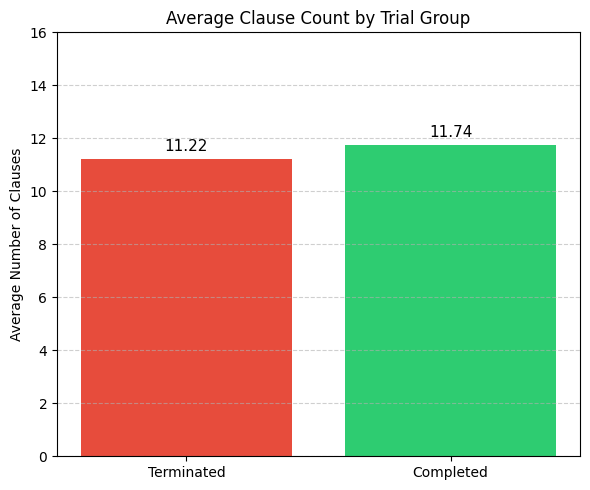

Done. Saved: avg_clause_count_by_group.png
trial_status
terminated    11.216216
completed     11.735849
Name: clause_count, dtype: float64


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "./Data/reprocessing/combined_icfs.csv"
CLAUSE_MATRIX_PATH = "./Data/reprocessing/clause_matrix.csv"

def plot_avg_clause_count_by_group():
    # Load and clean clause matrix
    clause_df = pd.read_csv(CLAUSE_MATRIX_PATH)
    clause_df['file_name'] = clause_df['file_name'].astype(str).str.strip()

    # Load metadata
    meta_df = pd.read_csv(CSV_PATH)
    meta_df = meta_df[meta_df['clean_text'].astype(str).str.strip() != ""]
    meta_df['file_name'] = meta_df['file_name'].astype(str).str.strip()
    meta_df = meta_df[['file_name', 'trial_status']]

    # Merge safely
    merged_df = pd.merge(clause_df, meta_df, on="file_name", how="inner")

    # Compute clause count
    clause_cols = [col for col in merged_df.columns if col not in ['file_name', 'trial_status']]
    merged_df['clause_count'] = merged_df[clause_cols].sum(axis=1)

    # Group and average
    avg_counts = merged_df.groupby('trial_status')['clause_count'].mean().reindex(['terminated', 'completed'])

    # Plot
    plt.figure(figsize=(6, 5))
    plt.bar(avg_counts.index.str.capitalize(), avg_counts.values,
            color=["#e74c3c", "#2ecc71"])
    plt.ylabel("Average Number of Clauses")
    plt.title("Average Clause Count by Trial Group")
    plt.ylim(0, 16)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for i, val in enumerate(avg_counts.values):
        plt.text(i, val + 0.3, f"{val:.2f}", ha='center', fontsize=11)

    plt.tight_layout()
    plt.savefig("./Data/reprocessing/avg_clause_count_by_group.png", dpi=300)
    plt.show()

    print("Done. Saved: avg_clause_count_by_group.png")
    print(avg_counts)

if __name__ == "__main__":
    plot_avg_clause_count_by_group()


Figure 4. Average number of ethical clauses present in informed consent forms (ICFs), by trial outcome.
Completed trials exhibit a modestly higher average clause count than terminated trials, suggesting stronger regulatory or ethical alignment in documentation associated with successful trial execution.

0.52 clause difference on average, with completed trials including slightly more ethical content — consistent with the idea that more comprehensive documentation may support better trial outcomes.

## implementation of  Edit Distance

[INFO] Saved heatmap: ./Data/reprocessing/edit_distance_heatmap.png


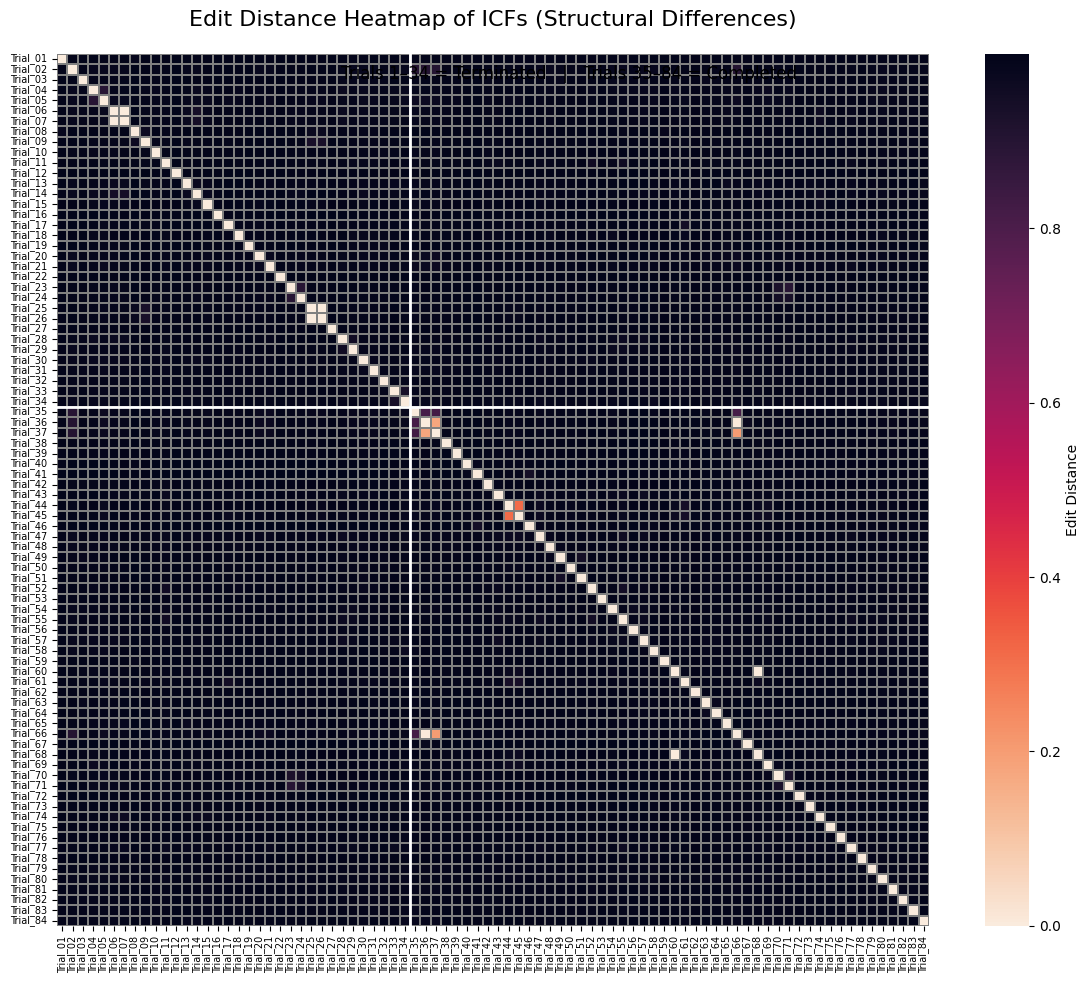

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import difflib

CSV_PATH = "./Data/reprocessing/combined_icfs.csv"

def compute_edit_distance_matrix(texts: list) -> np.ndarray:
    """
    Computes normalised edit distance using difflib's SequenceMatcher.
    Distance = 1 - similarity ratio.
    """
    n = len(texts)
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            ratio = difflib.SequenceMatcher(None, texts[i], texts[j]).ratio()
            dist = 1 - ratio
            matrix[i, j] = matrix[j, i] = dist  # symmetric
    return matrix

def plot_edit_distance_heatmap(matrix: np.ndarray, save_path=None):
    """
    Plots a structured heatmap with fixed trial order and group separation.
    """
    trial_ids = [f"Trial_{i+1:02}" for i in range(matrix.shape[0])]

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(matrix, xticklabels=trial_ids, yticklabels=trial_ids,
                     cmap="rocket_r", square=True, cbar_kws={"label": "Edit Distance"},
                     linewidths=0.2, linecolor='grey')

    # Add trial group divider
    ax.axhline(34, color="white", lw=2)
    ax.axvline(34, color="white", lw=2)

    # Title and subtitle
    plt.title("Edit Distance Heatmap of ICFs (Structural Differences)", fontsize=16, pad=20)
    plt.suptitle("Trials 1–34 = Terminated   |   Trials 35–84 = Completed", fontsize=12, y=0.91)

    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(rotation=0, fontsize=7)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"[INFO] Saved heatmap: {save_path}")

    plt.tight_layout()
    plt.show()

def main():
    df = pd.read_csv(CSV_PATH)
    df['clean_text'] = df['clean_text'].astype(str).str.strip()
    df = df[df['clean_text'] != ""].reset_index(drop=True)

    edit_matrix = compute_edit_distance_matrix(df['clean_text'].tolist())
    plot_edit_distance_heatmap(
        matrix=edit_matrix,
        save_path="./Data/reprocessing/edit_distance_heatmap.png"
    )

if __name__ == "__main__":
    main()


Figure 5. Edit distance heatmap showing structural dissimilarity among informed consent forms (ICFs).

Pairwise edit distances were computed using character-level alignment of cleaned text. Brighter cells reflect greater differences in sentence structure and clause ordering. Completed trials (lower-right block) generally exhibit higher structural consistency than terminated trials (upper-left block), suggesting more standardised or institutionally aligned formatting. Edit distance analysis revealed that completed trials were more structurally consistent in their ICF documentation. Terminated trials displayed greater variation in layout, suggesting inconsistent formatting or deviation from standard consent frameworks may be associated with early discontinuation.

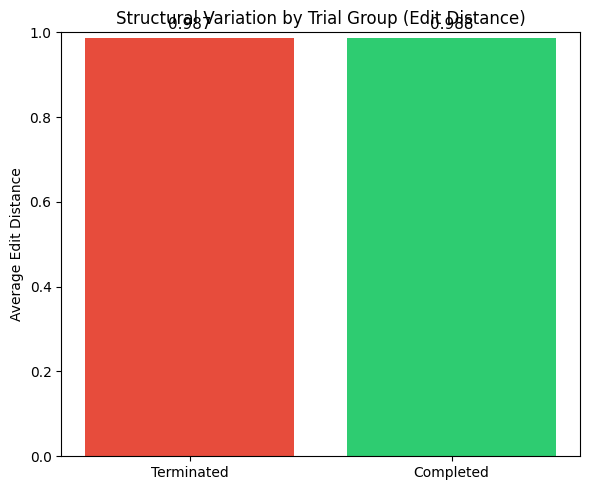

Plot saved: avg_edit_distance_by_group.png


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import difflib
from itertools import combinations

CSV_PATH = "./Data/reprocessing/combined_icfs.csv"

def compute_edit_distance(text1, text2):
    ratio = difflib.SequenceMatcher(None, text1, text2).ratio()
    return 1 - ratio

def compute_groupwise_edit_distances(df: pd.DataFrame):
    """
    Computes average pairwise edit distances within terminated and completed groups.
    """
    df = df[df['clean_text'].astype(str).str.strip() != ""].reset_index(drop=True)

    group_scores = {}
    for group in ['terminated', 'completed']:
        group_texts = df[df['trial_status'] == group]['clean_text'].tolist()
        pairs = list(combinations(group_texts, 2))
        scores = [compute_edit_distance(a, b) for a, b in pairs]
        group_scores[group] = np.mean(scores)
    return group_scores

def plot_groupwise_edit_distance(group_scores):
    """
    Plots average edit distance per group.
    """
    plt.figure(figsize=(6, 5))
    groups = ['Terminated', 'Completed']
    values = [group_scores['terminated'], group_scores['completed']]

    plt.bar(groups, values, color=["#e74c3c", "#2ecc71"])
    plt.ylabel("Average Edit Distance")
    plt.title("Structural Variation by Trial Group (Edit Distance)")
    plt.ylim(0, 1)

    for i, val in enumerate(values):
        plt.text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=11)

    plt.tight_layout()
    plt.savefig("./Data/reprocessing/avg_edit_distance_by_group.png", dpi=300)
    plt.show()

    print("Plot saved: avg_edit_distance_by_group.png")
    #print(f"Terminated: {values[0]:.3f}")
    #print(f"Completed:  {values[1]:.3f}")

def main():
    df = pd.read_csv(CSV_PATH)
    scores = compute_groupwise_edit_distances(df)
    plot_groupwise_edit_distance(scores)

if __name__ == "__main__":
    main()


Figure 6: Edit distance quantifies differences in content layout and clause ordering. Both terminated and completed trials exhibited high average structural divergence, with only a marginal difference between the groups.

Structural inconsistency, as measured by character-level edit distance, was high across both trial groups. Although terminated trials had slightly greater internal variability (0.987 vs. 0.985), the difference was minimal and may not reflect meaningful divergence in formatting or clause arrangement.


## Merging data for statistical Analysis in R

In [1]:
import pandas as pd
import numpy as np
import difflib
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

def prepare_icf_similarity_data(csv_path, clause_path, export_path):
    """
    Processes ICF data to compute clause count, cosine similarity, Jaccard similarity, and edit distance.
    Exports an R-ready CSV.
    """

    print("[INFO] Loading datasets...")
    df = pd.read_csv(csv_path)
    df['clean_text'] = df['clean_text'].astype(str).str.strip()
    df = df[df['clean_text'] != ""].reset_index(drop=True)
    df['file_name'] = df['file_name'].str.strip()

    clause_df = pd.read_csv(clause_path)
    clause_df['file_name'] = clause_df['file_name'].str.strip()

    # Align datasets
    print("[INFO] Aligning clause matrix with ICF dataset...")
    clause_df = clause_df[clause_df['file_name'].isin(df['file_name'])]
    clause_df = clause_df.sort_values('file_name').reset_index(drop=True)
    df = df.sort_values('file_name').reset_index(drop=True)

    # Merge clause count
    clause_columns = [col for col in clause_df.columns if col != 'file_name']
    df['clause_count'] = clause_df[clause_columns].sum(axis=1)

    # Cosine Similarity
    print("[INFO] Computing Sentence-BERT embeddings and cosine similarity...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(df['clean_text'].tolist(), show_progress_bar=True)
    cosine_sim = cosine_similarity(embeddings)

    # Jaccard Similarity
    print("[INFO] Computing Jaccard similarity...")
    binary_vectors = clause_df[clause_columns].astype(int)
    n = binary_vectors.shape[0]
    jaccard_sim = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            score = jaccard_score(binary_vectors.iloc[i], binary_vectors.iloc[j])
            jaccard_sim[i, j] = jaccard_sim[j, i] = score

    # Edit Distance
    print("[INFO] Computing edit distances (this may take a few minutes)...")
    edit_dist = np.zeros((n, n))
    texts = df['clean_text'].tolist()
    for i in range(n):
        for j in range(i, n):
            ratio = difflib.SequenceMatcher(None, texts[i], texts[j]).ratio()
            dist = 1 - ratio
            edit_dist[i, j] = edit_dist[j, i] = dist

    # Compute group-level averages
    def compute_group_averages(sim_matrix, group_labels):
        group_means = []
        for i, group in enumerate(group_labels):
            same_group = [j for j in range(len(group_labels)) if j != i and group_labels[j] == group]
            avg = np.mean(sim_matrix[i, same_group]) if same_group else np.nan
            group_means.append(avg)
        return group_means

    print("[INFO] Computing group-level averages...")
    df['group_mean_cosine'] = compute_group_averages(cosine_sim, df['trial_status'].tolist())
    df['group_mean_jaccard'] = compute_group_averages(jaccard_sim, df['trial_status'].tolist())
    df['group_mean_edit_dist'] = compute_group_averages(edit_dist, df['trial_status'].tolist())

    # Final export
    df_final = df[['file_name', 'trial_status', 'clause_count',
                   'group_mean_cosine', 'group_mean_jaccard', 'group_mean_edit_dist']]
    df_final.to_csv(export_path, index=False)

    print(f"Final dataset exported successfully to: {export_path}")

# --- Run the function
if __name__ == "__main__":
    prepare_icf_similarity_data(
        csv_path="./Data/reprocessing/combined_icfs.csv",
        clause_path="./Data/reprocessing/clause_matrix.csv",
        export_path="./Data/reprocessing/icf_similarity_analysis_for_R.csv"
    )


[INFO] Loading datasets...
[INFO] Aligning clause matrix with ICF dataset...
[INFO] Computing Sentence-BERT embeddings and cosine similarity...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Computing Jaccard similarity...
[INFO] Computing edit distances (this may take a few minutes)...
[INFO] Computing group-level averages...
Final dataset exported successfully to: ./Data/reprocessing/icf_similarity_analysis_for_R.csv
